## === Task ===

1. With the iris data given in class, implement train_test_split from scratch.

2. Put everything into a class called LogisticRegression, this class should allow you choose any of the training methods you'd like including "batch", "minibatch" and "sto". However, if the input method is not one of the three, it should "raise ValueError".

3. Calculate time taken to fit your models using different training methods.

4. Perform a classification on the dataset using all 3 methods and also show what happens if your defined training method is not either "batch", "minibatch" or "sto". Make sure to plot the training losses.

5. Simply, use classification_report from sklearn.metrics to evaluate your models.

6. Discuss your results ie. training losses of the three methods and time taken to fit models.

In [1]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report


#Step 1: Prepare data
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, 2:]  # we only take the first two features.
y = iris.target  #now our y is three classes thus require multinomial

# feature scaling helps improve reach convergence faster
scaler = StandardScaler()
X = scaler.fit_transform(X)

# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# add intercept to our X
intercept = np.ones((X_train.shape[0], 1))
X_train   = np.concatenate((intercept, X_train), axis=1)  #add intercept
intercept = np.ones((X_test.shape[0], 1))
X_test    = np.concatenate((intercept, X_test), axis=1)  #add intercept

# make sure our y is in the shape of (m, k)
# we will convert our output vector in 
# matrix where no. of columns is equal to the no. of classes. 
# The values in the matrix will be 0 or 1. For instance the rows 
# where we have output 2 the column 2 will contain 1 and the rest are all 0.
# in simple words, y will be of shape (m, k)
k = len(set(y))  # no. of class  (can also use np.unique)
m = X_train.shape[0]  # no. of samples
n = X_train.shape[1]  # no. of features
Y_train_encoded = np.zeros((m, k))
for each_class in range(k):
    cond = y_train==each_class
    Y_train_encoded[np.where(cond), each_class] = 1

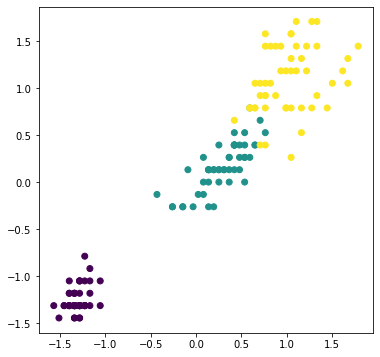

In [2]:
# Step 1.1 (optional): Visualize our data

# your code here
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], label='class 0', c=y)
plt.show()

In [9]:
#check shape
print(k)
print(Y_train_encoded.shape)     #<---should be (m,k)
print(X.shape)                   #<---should be (m,n)

3
(105, 3)
(150, 2)


In [24]:
# Step 2: Fit your data

class LogisticRegression:
    
    def __init__(self, k, n, method, alpha=0.0001, max_iter=10000):    #<-----Becareful non-default argument should not follow the default argument. i.e.(a = 'b',c)
        self.k = k
        self.n = n
        self.alpha = alpha
        self.max_iter = max_iter
        self.method = method
        
    def fit(self, X, Y):
        '''
        Inputs: 
            X shape: (m, n)
            theta shape: (n, k)
        '''
        self.theta = np.random.rand(self.n, self.k)
        self.losses = []
        
        ##################### selected the method ########################
        #<------------------------"mini-batch"
        #<------------------------selected some data
        if self.method == "mini-batch":
            start_time = time.time()     #<--------time!!!!!
            batch_size = int(0.1 * X.shape[0])
            for i in range(self.max_iter):
                ix = np.random.randint(0, X.shape[0])     #<----with replacement
                batch_X = X[ix:ix+batch_size]
                batch_Y = Y[ix:ix+batch_size]
                loss, grad = self.gradient(batch_X, batch_Y)     #<----some data
                self.losses.append(loss)
                self.theta = self.theta - self.alpha * grad      #update the theta
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print("Time taken: ", time.time()-start_time)
        
        #<------------------------"batch"
        #<------------------------selected all data
        elif self.method == "batch":
            start_time = time.time()     #<--------time!!!!!
            for i in range(self.max_iter):
                loss, grad = self.gradient(X, Y)                 #<----all data
                self.losses.append(loss)
                self.theta = self.theta - self.alpha * grad      #update the theta
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print("Time taken: ", time.time()-start_time)
        
        #<------------------------"sto"
        #<------------------------selected one data
        elif self.method == "sto":
            start_time = time.time()     #<--------time!!!!!
            list_of_used_ix = []
            for i in range(self.max_iter):
                ix = np.random.randint(X.shape[0])
                while i in list_of_used_ix:
                    ix = np.random.randint(X.shape[0])
                X_train = X[ix, :].reshape(1, -1)
                Y_train = Y[ix]
                loss, grad =  self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.theta = self.theta - self.alpha * grad      #update the theta              
                list_of_used_ix.append(i)
                
                if len(list_of_used_ix) == X.shape[0]:
                    list_of_used_ix = []
                
                if i % 500 == 0:
                    print(f"Cost at iteration {i}", loss)
            print("Time taken: ", time.time()-start_time)  
                
        #<------------------------ValueError        
        else:
            raise ValueError('Please select one of the following method: "batch", "mini-batch" or "sto".')
        
        
    def gradient(self, X, Y):
        m = X.shape[0]
        h = self.h_theta(X, self.theta)
        error = h - Y
        # putting negative sign for negative log likelihood
        loss = - np.sum(Y * np.log(h)) / m
        grad = self.softmax_grad(X, error)
        return loss, grad

    def softmax(self, theta_t_x):
        return np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return  X.T @ error
        
    def h_theta(self, X, theta):
        '''
        Input:
            X shape: (m, n)
            theta shape: (n, k)
        Returns:
            yhat shape: (m, k)
        '''
        return self.softmax(X @ theta)
    
    def predict(self, X_test):     #the output(predict) from the data of X_test
        yhat = np.argmax(self.h_theta(X_test, self.theta), axis=1)      
        return yhat
        
    def plot(self):
        plt.plot(np.arange(len(self.losses)), self.losses, label = 'Train Losses')  
        plt.title("Losses")
        plt.xlabel("X(epoch)")
        plt.ylabel("Y(losses)")
        plt.legend()

Loss at iteration 0 1.0411228187119357
Loss at iteration 500 1.076349147047622
Loss at iteration 1000 1.0072754114195095
Loss at iteration 1500 0.6725262266205112
Loss at iteration 2000 0.7790554663646498
Loss at iteration 2500 0.5338066930078786
Loss at iteration 3000 0.5258861676833615
Loss at iteration 3500 0.8334815173369081
Loss at iteration 4000 0.36766604591101626
Loss at iteration 4500 0.43687858674710994
Loss at iteration 5000 0.551357121108502
Loss at iteration 5500 0.681940966877831
Loss at iteration 6000 0.496595380156735
Loss at iteration 6500 0.5784575297412192
Loss at iteration 7000 0.4006824651879639
Loss at iteration 7500 0.5161484833347456
Loss at iteration 8000 0.5869071494936461
Loss at iteration 8500 0.43110194436757
Loss at iteration 9000 0.4196767242610826
Loss at iteration 9500 0.2585475202238467
Time taken:  0.5770673751831055
---------------Classification report------------------
Report:                precision    recall  f1-score   support

           0     

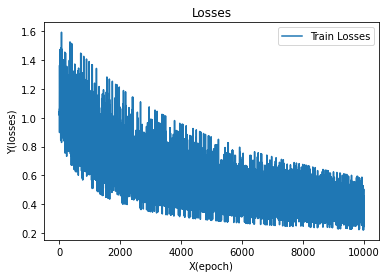

In [25]:
#<------------------------"mini-batch"
#<------------------------selected some data
model = LogisticRegression(k, X_train.shape[1], "mini-batch")
model.fit(X_train, Y_train_encoded)
yhat = model.predict(X_test)
model.plot()
print("---------------Classification report------------------")
print("Report: ", classification_report(y_test, yhat))

Loss at iteration 0 1.096703348002143
Loss at iteration 500 0.4643023877541037
Loss at iteration 1000 0.35516586232930364
Loss at iteration 1500 0.2947145737386764
Loss at iteration 2000 0.2552998750864511
Loss at iteration 2500 0.22741811462243863
Loss at iteration 3000 0.2066163262568443
Loss at iteration 3500 0.1904846010258076
Loss at iteration 4000 0.17759711516156182
Loss at iteration 4500 0.16705522428434144
Loss at iteration 5000 0.1582644270637013
Loss at iteration 5500 0.1508158376429706
Loss at iteration 6000 0.1444190536652872
Loss at iteration 6500 0.13886216233169063
Loss at iteration 7000 0.13398690118502632
Loss at iteration 7500 0.12967267928375426
Loss at iteration 8000 0.12582598299457456
Loss at iteration 8500 0.12237316467487647
Loss at iteration 9000 0.11925541910236344
Loss at iteration 9500 0.1164252113094833
Time taken:  0.6083838939666748
---------------Classification report------------------
Report:                precision    recall  f1-score   support

    

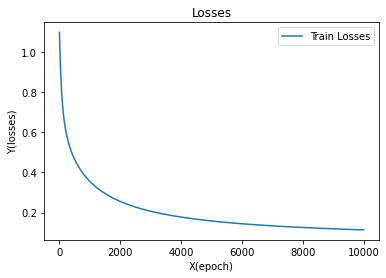

In [26]:
#<------------------------"batch"
#<------------------------selected all data
model = LogisticRegression(k, X_train.shape[1], "batch")
model.fit(X_train, Y_train_encoded)
yhat = model.predict(X_test)
model.plot()
print("---------------Classification report------------------")
print("Report: ", classification_report(y_test, yhat))

Cost at iteration 0 0.45294407336543824
Cost at iteration 500 1.0711938013528939
Cost at iteration 1000 1.2732825812473911
Cost at iteration 1500 0.3872475004466772
Cost at iteration 2000 1.0498257871243168
Cost at iteration 2500 1.0132183653330449
Cost at iteration 3000 1.0747077491478576
Cost at iteration 3500 0.38366313766547133
Cost at iteration 4000 0.9724675432468317
Cost at iteration 4500 0.9018133999258853
Cost at iteration 5000 1.0340521918392043
Cost at iteration 5500 1.0315574636660478
Cost at iteration 6000 0.9378446995385723
Cost at iteration 6500 0.24387101110268194
Cost at iteration 7000 0.2762970206331161
Cost at iteration 7500 1.020948088329379
Cost at iteration 8000 0.2578775676626013
Cost at iteration 8500 0.8603610672894859
Cost at iteration 9000 0.2466417200070131
Cost at iteration 9500 0.2793317922539585
Time taken:  0.5887134075164795
---------------Classification report------------------
Report:                precision    recall  f1-score   support

           

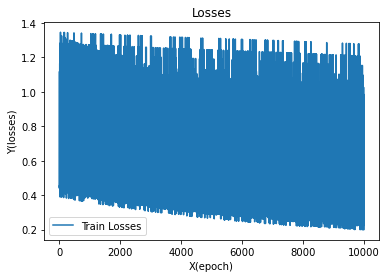

In [27]:
#<------------------------"sto"
#<------------------------selected one data
model = LogisticRegression(k, X_train.shape[1], "sto")
model.fit(X_train, Y_train_encoded)
yhat = model.predict(X_test)
model.plot()
print("---------------Classification report------------------")
print("Report: ", classification_report(y_test, yhat))

In [28]:
#<------------------------ValueError    
model = LogisticRegression(k, X_train.shape[1], "OMG")
model.fit(X_train, Y_train_encoded)
yhat = model.predict(X_test)
model.plot()
print("---------------Classification report------------------")
print("Report: ", classification_report(y_test, yhat))

ValueError: Please select one of the following method: "batch", "mini-batch" or "sto".